# C2
# Предсказание отмены такси

## курс "Машинное обучение 2", программа OzonMasters, 2022

## Студент: Арешин Станислав Олегович

## Baseline 2

В данном ноутбуке представлено решение, побившее второй бейслайн. (Скор решения при использовании всех данных на паблике 0.74958 при бейслайне 0.69283). В целом это решение отличается от решения, которое побило первый бейслайн, набором сгенерированных признаков. В решении первого бейслайна использовались только временные признаки и ohe hot кодирование категорий с тем же catboost, поэтому код первого бейслайна я отдельно приводить не буду.

**Что же помогло побить второй бейслайн?**

* Наибольший прирост к скору дали признаки, составленные из почти дубликатов заказов (функция find_almost_dupclicates). Идея функции описана в разделе с данной функцией.
* Также хорошо сработали расстояния до центров городов и минимальное расстояние до города (функция get_dists_from_cities)
* От погодных данных становилось только хуже, так как они едут из-за смены времени года (см weather_data_eda.ipynb), поэтому их я не использую.
* Остальное по порядку по ходу ноутбука)

**В ноутбуке описана основа решения, представлены оценки модели на валидационной выборке. Это не итоговое решение. В итоговом решении я применил блендинг на всех данных с теми же признаками и немного увеличил скор. Ноутбук с блендингом тоже прилагается.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Загрузка данных

Сразу подгружаю данные с рассчитанными расстояними до городов, так как сама функция работает долговато и проще посчитать один раз и сохранить. Данные сортируем по due для дальнейшего поиска почти дубликатов, потом вернем обратно.

In [2]:
df = pd.read_csv('1_data/train_data_w_dists.csv')
target = pd.read_csv('1_data/train_target.csv')
df['target'] = np.array(target)
df = df.sort_values('due')
print(df.shape)
df.head()

(1187461, 14)


,dist,due,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,dist_to_N_NOVGOROD,dist_to_VORONEZH,min_dist_to_city,target
823150,17990.125431,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,0.206023,8.577844,11.243127,6.209581,4.315741,0.206023,1
685195,2322.180999,2014-01-01 00:10:00.000,econom,55.711488,37.884183,NaN,NaN,0.270543,8.649893,11.182532,6.152650,4.259919,0.270543,0
996389,14608.577392,2014-01-01 00:10:00.000,econom,55.633404,37.797595,NaN,NaN,0.217931,8.613152,11.270209,6.246994,4.213747,0.217931,0
497811,20055.569096,2014-01-01 00:10:00.000,econom,55.780380,37.645240,NaN,NaN,0.037198,8.407917,11.420952,6.384175,4.404071,0.037198,0
812346,20585.444093,2014-01-01 00:10:00.000,econom,55.675676,37.500387,NaN,NaN,0.141746,8.335291,11.566730,6.538104,4.360663,0.141746,1


In [3]:
df_test = pd.read_csv('1_data/test_data_w_dists.csv')
df_test = df_test.sort_values('due')
print(df_test.shape)

df_test.head()

(510937, 13)


,dist,due,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,dist_to_N_NOVGOROD,dist_to_VORONEZH,min_dist_to_city
418832,12228.949942,2014-03-06 08:00:00.000,econom,55.709632,37.767186,business,NaN,0.156845,8.548894,11.299542,6.269254,4.295751,0.156845
330723,11792.691777,2014-03-06 08:00:00.000,business,55.867147,37.665435,NaN,NaN,0.121284,8.383043,11.400706,6.357193,4.478395,0.121284
440585,1424.111651,2014-03-06 08:00:00.000,econom,55.747110,37.642815,business,NaN,0.026964,8.422299,11.423571,6.389524,4.373822,0.026964
462500,487.808926,2014-03-06 08:00:00.000,econom,55.744936,37.615057,business,NaN,0.011117,8.399310,11.451344,6.417364,4.381755,0.011117
75315,2503.594134,2014-03-06 08:00:00.000,econom,55.762961,37.619647,business,NaN,0.007513,8.394317,11.446634,6.411183,4.396913,0.007513


# get_dists_from_cities

Вычисление евклидовых расстояний до центров городов и минимального расстояния до города. Хорошие признаки, но считаются долго (у меня 45 минут для всех данных).

In [4]:
from scipy.spatial import distance

def get_dists_from_cities(row):
    MOSCOW = np.array([55.755825, 37.617298])
    SPB = np.array([59.934280, 30.335098])
    KAZAN = np.array([55.830433, 49.066082])
    N_NOVGOROD = np.array([56.326790, 44.005989])
    VORONEZH = np.array([51.659908, 39.200089])
    dist_to_MOSCOW = distance.euclidean(row[['lat', 'lon']], MOSCOW)
    dist_to_SPB = distance.euclidean(row[['lat', 'lon']], SPB)
    dist_to_KAZAN = distance.euclidean(row[['lat', 'lon']], KAZAN)
    dist_to_N_NOVGOROD = distance.euclidean(row[['lat', 'lon']], N_NOVGOROD)
    dist_to_VORONEZH = distance.euclidean(row[['lat', 'lon']], VORONEZH)
    min_dist_to_city = np.min([dist_to_MOSCOW, dist_to_SPB, dist_to_KAZAN, dist_to_N_NOVGOROD, dist_to_VORONEZH]) 
    return dist_to_MOSCOW, dist_to_SPB, dist_to_KAZAN, dist_to_N_NOVGOROD, dist_to_VORONEZH, min_dist_to_city

In [ ]:
%%time

# ~30 минут

df[['dist_to_MOSCOW', 'dist_to_SPB', 'dist_to_KAZAN', 'dist_to_N_NOVGOROD',\
          'dist_to_VORONEZH', 'min_dist_to_city']] = df[['lat', 'lon']].apply(\
                                                        get_dists_from_cities, result_type='expand', axis=1)

In [ ]:
%%time

# ~15 минут

df_test[['dist_to_MOSCOW', 'dist_to_SPB', 'dist_to_KAZAN', 'dist_to_N_NOVGOROD',\
          'dist_to_VORONEZH', 'min_dist_to_city']] = df_test[['lat', 'lon']].apply(\
                                                        get_dists_from_cities, result_type='expand', axis=1)

In [3]:
# df.to_csv('1_data/train_data_w_dists.csv', index=False)
# df_test.to_csv('1_data/test_data_w_dists.csv', index=False)

# Обучающая выборка

Выделим валидационную выборку для оценки качества как 20 процентов данных с конца, так как данные теста тоже из будущего.

In [5]:
df_train = df[:int(len(df) * 0.8)].copy()
df_val = df[int(len(df) * 0.8) :].copy()

print(f'Train shape : {df_train.shape}')
print(f'Val shape : {df_val.shape}')

Train shape : (949968, 14)
Val shape : (237493, 14)


Сверим баланс таргета на обучении и валидации.

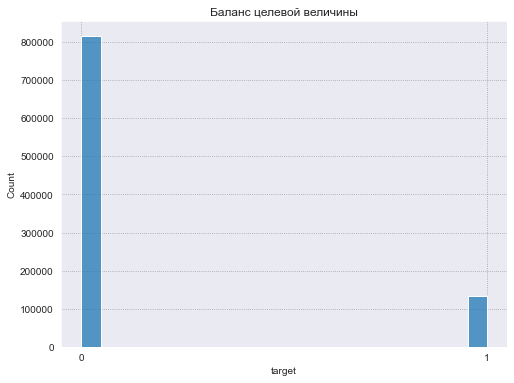

In [6]:
plt.figure(figsize=(8,6))
plt.title('Баланс целевой величины')
sns.histplot(data=df_train, x='target')
plt.xticks([0,1])
plt.show()

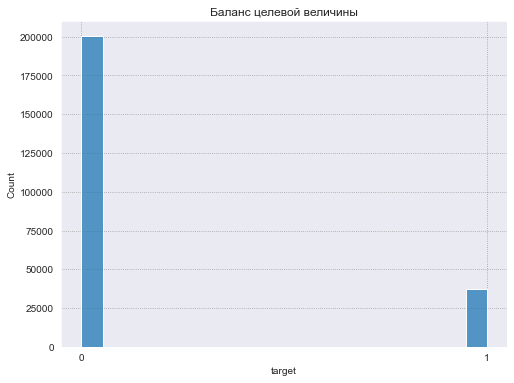

In [7]:
plt.figure(figsize=(8,6))
plt.title('Баланс целевой величины')
sns.histplot(data=df_val, x='target')
plt.xticks([0,1])
plt.show()

Вроде все честно))

# get_datetime_features

Признаки, выделенные из даты и времени. Они помогли побить первый бейслайн, также помогли для джоина погоды в weather_data_eda.ipynb и для поиска почти дубликатов. В общем - супер признаки). Отмечу, что до раскрытия первого бейслайна я не выделял 'total_minutes' и 'total_seconds', но этого все равно хватило.

In [8]:
def get_datetime_features(df):
    df_res = df.copy()
    df_res['due_datetime'] = pd.to_datetime(df_res['due'])
    df_res['month'] = df_res['due_datetime'].dt.month
    df_res['day'] = df_res['due_datetime'].dt.day
    df_res['weekday'] = df_res['due_datetime'].dt.weekday
    df_res['is_weekend'] = df_res.apply(lambda row: 1 if  row['weekday'] > 4\
                                           else 0, axis=1)
    df_res['hour'] = df_res['due_datetime'].dt.hour
    df_res['day_period'] = (df_res['hour'] % 24 + 4) // 4
    
    df_res['time_as_str'] = df_res['due'].apply(lambda x: x[x.find(' ') + 1:-4])
    df_res['due_timedelta'] = pd.to_timedelta(df_res['time_as_str'])
    df_res['total_seconds'] = df_res['due_timedelta'].dt.total_seconds()
    df_res['total_minutes'] = df_res['total_seconds'] // 60
    
    df_res.drop(['time_as_str', 'due_timedelta', 'due_datetime', 'due'], inplace=True, axis=1)
    return df_res  

In [9]:
%%time 

df_train = get_datetime_features(df_train)

df_val = get_datetime_features(df_val)

df_test = get_datetime_features(df_test)

Wall time: 56.6 s


# get_geo_features

Данную функцию я позаимствовал из открытого ноутбука, немного переписал под себя. В тесте есть перепутанные lat lon, в обучении их нет, а признак очень важный, это надо исправить.

In [10]:
def get_geo_features(df, test=False):
    df_res = df.copy()
    df_res['city'] = 'other'
    df_res.loc[df_res['lat'].between(59.4, 60.3) & df_res['lon'].between(29.23, 31.394), 'city'] = 'spb'
    df_res.loc[df_res['lat'].between(54.35, 56.7) & df_res['lon'].between(35.05, 39.86), 'city'] = 'moscow'
    df_res.loc[df_res['lat'].between(49.68, 52.03) & df_res['lon'].between(37.68, 43.35), 'city'] = 'voronezh'
    df_res.loc[df_res['lat'].between(55.95, 56.45) & df_res['lon'].between(43.38, 44.76), 'city'] = 'nnovgorod'
    df_res.loc[df_res['lat'].between(55.46, 55.94) & df_res['lon'].between(48.54, 50.06), 'city'] = 'kazan'
    
    if test:
        df_res['lat'], df_res['lon'] = np.where(df_res['city']=='other',\
                                                (df_res['lon'],df_res['lat']),(df_res['lat'],df_res['lon']))
        df_res.loc[df_res['lat'].between(59.4, 60.3) & df_res['lon'].between(29.23, 31.394), 'city'] = 'spb'
        df_res.loc[df_res['lat'].between(54.35, 56.7) & df_res['lon'].between(35.05, 39.86), 'city'] = 'moscow'
        df_res.loc[df_res['lat'].between(49.68, 52.03) & df_res['lon'].between(37.68, 43.35), 'city'] = 'voronezh'
        df_res.loc[df_res['lat'].between(55.95, 56.45) & df_res['lon'].between(43.38, 44.76), 'city'] = 'nnovgorod'
        df_res.loc[df_res['lat'].between(55.46, 55.94) & df_res['lon'].between(48.54, 50.06), 'city'] = 'kazan'
    return df_res  

In [11]:
%%time

df_train = get_geo_features(df_train)
df_val = get_geo_features(df_val)
df_test = get_geo_features(df_test, test=True)

Wall time: 537 ms


# find_almost_duplicates

Самая важная функция данного решения. Благодаря этим признакам был побит второй бейслайн. Давайте подумаем, почему человек мог отменить заказ до того, как его взял таксист? Ниже несколько вариантов:

* Человек заказал случайно в другое место, потом отменил и заказал в нужное.
* Человек резко передумал ехать именно сейчас и поехал позже (например отговорили друзья или появились срочные дела). Тогда он закажет и поедет позже : через несколько минут, несколько часов, в в другое время суток и тд.

Напрашивается идея искать похожие по таким критериям заказы, приняв последний похожий заказ как не дубликат, а остальные помечать как дубликаты (для этого была сортировка по due в самом начале). Из этой идеи получается прекрасный признак. Можно придумать несколько комбинаций, по которым будем искать почти дубликаты, и нагенерировать дополнительные признаки, которые помогут итоговой модельке. Ниже реализован код такой функции.

In [12]:
# предварительно отсортировать данные
def find_almost_dupclicates(df):
    df_res = df.copy()
    df_res['lat_lon_duplicated'] = df_res.duplicated(subset=['lat', 'lon'], keep='last')
    df_res['dist_lat_lon_duplicated'] = df_res.duplicated(subset=['dist', 'lat', 'lon'], keep='last')
    df_res['dist_lat_lon_classes_duplicated'] = df_res.duplicated(subset=['dist', 'lat', 'lon', 'f_class','s_class','t_class'], keep='last')
    df_res['day_lat_lon_duplicated'] = df_res.duplicated(subset=['month', 'day', 'lat', 'lon'], keep='last')
    df_res['dayperiod_lat_lon_duplicated'] = df_res.duplicated(subset=['month', 'day','day_period', 'lat', 'lon'], keep='last')
    df_res['hour_lat_lon_duplicated'] = df_res.duplicated(subset=['month', 'day','hour', 'lat', 'lon'], keep='last')
    df_res['minutes_lat_lon_duplicated'] = df_res.duplicated(subset=['month', 'day','total_minutes', 'lat', 'lon'], keep='last')
    df_res['dist_day_lat_lon_duplicated'] = df_res.duplicated(subset=['dist','month', 'day', 'lat', 'lon'], keep='last')
    df_res['dist_dayperiod_lat_lon_duplicated'] = df_res.duplicated(subset=['dist','month', 'day','day_period', 'lat', 'lon'], keep='last')
    df_res['dist_hour_lat_lon_duplicated'] = df_res.duplicated(subset=['dist','month', 'day','hour', 'lat', 'lon'], keep='last')
    return df_res

In [ ]:
df_train = find_almost_dupclicates(df_train)
df_val = find_almost_dupclicates(df_val)
df_test = find_almost_dupclicates(df_test)

Построим несколько визуализаций разделений 

In [14]:
df_train.columns

Index(['dist', 'f_class', 'lat', 'lon', 's_class', 't_class', 'dist_to_MOSCOW',
       'dist_to_SPB', 'dist_to_KAZAN', 'dist_to_N_NOVGOROD',
       'dist_to_VORONEZH', 'min_dist_to_city', 'target', 'month', 'day',
       'weekday', 'is_weekend', 'hour', 'day_period', 'total_seconds',
       'total_minutes', 'city', 'lat_lon_duplicated',
       'dist_lat_lon_duplicated', 'dist_lat_lon_classes_duplicated',
       'day_lat_lon_duplicated', 'dayperiod_lat_lon_duplicated',
       'hour_lat_lon_duplicated', 'minutes_lat_lon_duplicated',
       'dist_day_lat_lon_duplicated', 'dist_dayperiod_lat_lon_duplicated',
       'dist_hour_lat_lon_duplicated'],
      dtype='object')

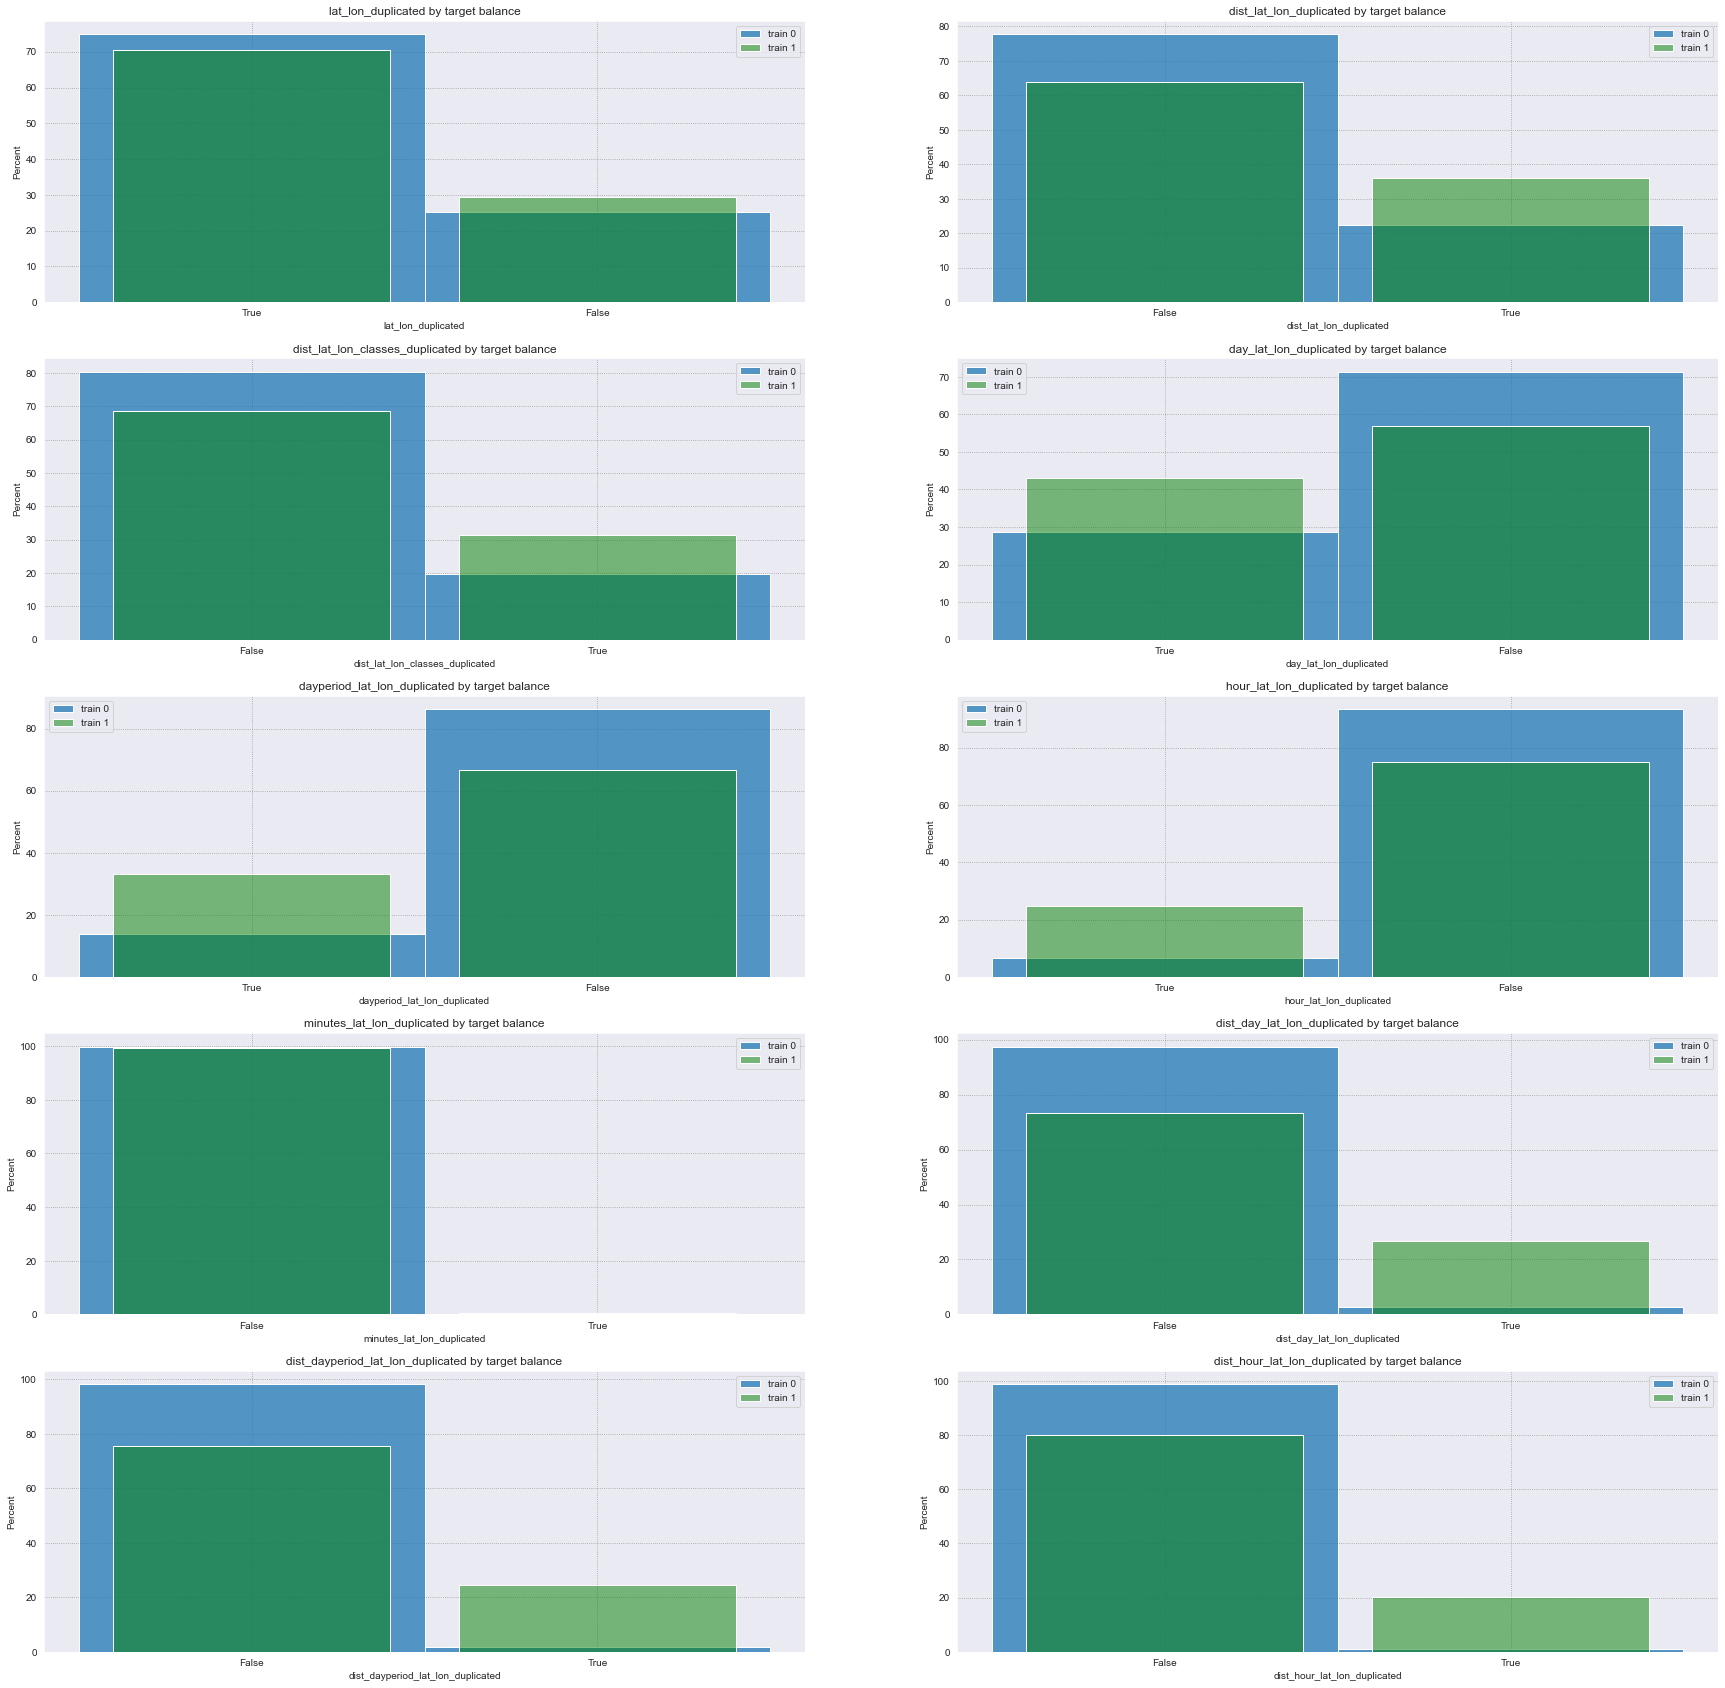

In [18]:
df_train_plot = df_train.copy()

features = ['lat_lon_duplicated', 'dist_lat_lon_duplicated', 'dist_lat_lon_classes_duplicated',\
       'day_lat_lon_duplicated', 'dayperiod_lat_lon_duplicated', 'hour_lat_lon_duplicated',\
        'minutes_lat_lon_duplicated', 'dist_day_lat_lon_duplicated', 'dist_dayperiod_lat_lon_duplicated',\
       'dist_hour_lat_lon_duplicated']

df_train_plot[features] = df_train_plot[features].astype(str)

fig = plt.figure(figsize=(30, 30))
plt.axis('off')

for i, feat in enumerate(features):
    ax = fig.add_subplot(int(len(features) / 2), 2, i + 1)
    ax.set_title(f'{feat} by target balance')
    sns.histplot(data=df_train_plot[df_train_plot['target'] == 0], x=feat, label='train 0', ax=ax, stat='percent')
    sns.histplot(data=df_train_plot[df_train_plot['target'] == 1], x=feat, label='train 1', ax=ax,\
                     color='green', stat='percent', shrink=.8, alpha=.5)
    ax.set_xlabel(feat)
    ax.legend(['train 0', 'train 1'])

Некоторые признаки прямо ну очень хороши для разделения, и они помогут итоговой модели в решении поставленной задачи.

# Шафлим train и val, восстанавливем порядок test

Так как в самом начале при загрузке данных они были отсортированы по времени, восстановим исходный порядок тестовой выборки, а обучение и валидацию можно просто пошафлить.

In [19]:
df_train = df_train.sample(frac=1, random_state=42)
df_val = df_val.sample(frac=1, random_state=42)
df_test = df_test.sort_index()
df_test.head()

,dist,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,dist_to_N_NOVGOROD,...,lat_lon_duplicated,dist_lat_lon_duplicated,dist_lat_lon_classes_duplicated,day_lat_lon_duplicated,dayperiod_lat_lon_duplicated,hour_lat_lon_duplicated,minutes_lat_lon_duplicated,dist_day_lat_lon_duplicated,dist_dayperiod_lat_lon_duplicated,dist_hour_lat_lon_duplicated
0,4611.506701,econom,55.776618,37.682503,NaN,NaN,0.068440,8.442187,11.383706,6.347375,...,False,False,False,False,False,False,False,False,False,False
1,14450.067441,econom,55.754659,37.810072,NaN,NaN,0.192778,8.564138,11.256265,6.222276,...,True,False,False,False,False,False,False,False,False,False
2,17755.993723,business,55.726141,37.587407,NaN,NaN,0.042127,8.384773,11.479149,6.446626,...,False,False,False,False,False,False,False,False,False,False
3,8533.172059,econom,55.794178,37.576456,business,NaN,0.056027,8.341325,11.489683,6.451556,...,True,False,False,False,False,False,False,False,False,False
4,-1.000000,econom,55.757409,37.542186,business,NaN,0.075129,8.329968,11.524127,6.488832,...,True,True,False,False,False,False,False,False,False,False


# Избавляемся от нанов

Пропуски были только в категориальных переменных, поэтому заполним их отдельной категорией.

In [20]:
cols_to_fill_newcat1 = ['f_class', 's_class', 't_class']

In [21]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='constant', fill_value='unknown')

to_fill_train = np.array(df_train[cols_to_fill_newcat1])
fill_result_train = imp.fit_transform(to_fill_train)
df_train[cols_to_fill_newcat1] = fill_result_train

to_fill_val = np.array(df_val[cols_to_fill_newcat1])
fill_result_val = imp.transform(to_fill_val)
df_val[cols_to_fill_newcat1] = fill_result_val

to_fill_test = np.array(df_test[cols_to_fill_newcat1])
fill_result_test = imp.transform(to_fill_test)
df_test[cols_to_fill_newcat1] = fill_result_test

Функция, которая создаёт признак того, что признак не нан. Небольшая помощь модельке. В признаке dist значением -1 ещё до этапа предоставления данных были заполнены наны, так что это тоже отметим.

In [22]:
def is_feature(df, val_cols, cat_cols):
    df_res = df.copy()
    for col in val_cols:
        df_res[f'is_{col}'] = (df_res[col] != -1.0).astype(int)
    for col in cat_cols:
        df_res[f'is_{col}'] = (df_res[col] != 'unknown').astype(int)
    return df_res

In [23]:
val_cols =  ['dist']
cat_cols = ['f_class', 's_class', 't_class']
df_train = is_feature(df_train, val_cols, cat_cols)
df_val = is_feature(df_val, val_cols, cat_cols)
df_test = is_feature(df_test, val_cols, cat_cols)

# Encoding

Я принял решение использовать бустинг, поэтому достаточно будет использовать OrdinalEncoder.

In [24]:
y_train = np.array(df_train['target'])
y_val = np.array(df_val['target'])

df_train.drop(['target'], axis=1, inplace=True)
df_val.drop(['target'], axis=1, inplace=True)

In [25]:
from category_encoders import OrdinalEncoder

cat_columns = list(df_train.select_dtypes('object').columns)
encoder = OrdinalEncoder(cols = cat_columns)

df_train_encoded = encoder.fit_transform(df_train)
df_val_encoded = encoder.transform(df_val)
df_test_encoded = encoder.transform(df_test)

print(df_train_encoded.shape)
print(df_val_encoded.shape)
print(df_test_encoded.shape)

df_train_encoded.head()

(949968, 35)
(237493, 35)
(510937, 35)


,dist,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,dist_to_N_NOVGOROD,...,dayperiod_lat_lon_duplicated,hour_lat_lon_duplicated,minutes_lat_lon_duplicated,dist_day_lat_lon_duplicated,dist_dayperiod_lat_lon_duplicated,dist_hour_lat_lon_duplicated,is_dist,is_f_class,is_s_class,is_t_class
275245,7528.434304,1,55.827530,37.593605,1,1,0.075518,8.339743,11.472477,6.431791,...,False,False,False,False,False,False,1,1,0,0
365753,16980.759249,2,55.806606,37.714815,1,1,0.109947,8.455644,11.351292,6.312643,...,False,False,False,False,False,False,1,1,0,0
43841,1388.981069,1,55.740522,37.581963,2,1,0.038506,8.372852,11.484471,6.450722,...,False,False,False,False,False,False,1,1,1,0
19329,4304.376186,1,55.763933,37.609290,2,1,0.011396,8.384847,11.456985,6.421415,...,False,False,False,False,False,False,1,1,1,0
470891,14004.675039,1,55.702825,37.569971,1,1,0.071055,8.381444,11.496819,6.466194,...,False,False,False,False,False,False,1,1,0,0


In [26]:
df_train_encoded.columns

Index(['dist', 'f_class', 'lat', 'lon', 's_class', 't_class', 'dist_to_MOSCOW',
       'dist_to_SPB', 'dist_to_KAZAN', 'dist_to_N_NOVGOROD',
       'dist_to_VORONEZH', 'min_dist_to_city', 'month', 'day', 'weekday',
       'is_weekend', 'hour', 'day_period', 'total_seconds', 'total_minutes',
       'city', 'lat_lon_duplicated', 'dist_lat_lon_duplicated',
       'dist_lat_lon_classes_duplicated', 'day_lat_lon_duplicated',
       'dayperiod_lat_lon_duplicated', 'hour_lat_lon_duplicated',
       'minutes_lat_lon_duplicated', 'dist_day_lat_lon_duplicated',
       'dist_dayperiod_lat_lon_duplicated', 'dist_hour_lat_lon_duplicated',
       'is_dist', 'is_f_class', 'is_s_class', 'is_t_class'],
      dtype='object')

# Creating model

Создаём модель. Используем CatBoostClassifier. Модель практически не тюнилась (немного ручками), но показывает довольно хорошие результаты.

In [27]:
X_train = np.array(df_train_encoded)
X_val = np.array(df_val_encoded)
X_test = np.array(df_test_encoded)


print(f'Train shape : {X_train.shape}')
print(f'Val shape : {X_val.shape}')
print(f'Test shape : {X_test.shape}')

Train shape : (949968, 35)
Val shape : (237493, 35)
Test shape : (510937, 35)


In [28]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000,
                            loss_function = 'Logloss',
                            task_type="CPU",
                            max_depth=9,
                            learning_rate= 0.1,
                            random_state=1
                            )

model.fit(X = X_train,
          y = y_train, 
          verbose = 100,
          early_stopping_rounds=50)

0:	learn: 0.6148444	total: 851ms	remaining: 14m 10s
100:	learn: 0.3350931	total: 55.1s	remaining: 8m 10s
200:	learn: 0.3308353	total: 1m 51s	remaining: 7m 23s
300:	learn: 0.3272181	total: 2m 46s	remaining: 6m 25s
400:	learn: 0.3240791	total: 3m 42s	remaining: 5m 32s
500:	learn: 0.3212054	total: 4m 38s	remaining: 4m 37s
600:	learn: 0.3184392	total: 5m 35s	remaining: 3m 43s
700:	learn: 0.3158847	total: 6m 33s	remaining: 2m 47s
800:	learn: 0.3135711	total: 7m 28s	remaining: 1m 51s
900:	learn: 0.3111737	total: 8m 24s	remaining: 55.5s
999:	learn: 0.3089748	total: 9m 19s	remaining: 0us


roc_auc_score = 0.740848867735586

In [29]:
from sklearn.metrics import roc_auc_score

val_preds = model.predict_proba(X_val)[:, 1]

print(f'roc_auc_score = {roc_auc_score(y_val.reshape(-1), val_preds)}')

roc_auc_score = 0.740848867735586


Ниже представлен график важности признаков. Видно, что новые признаки были нагенерированы хорошо))

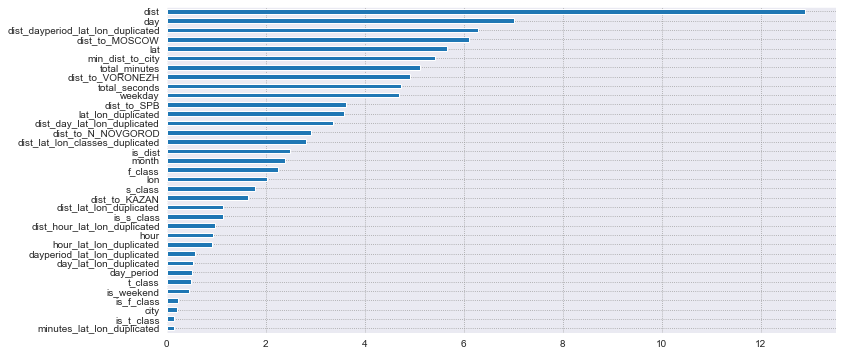

In [30]:
feat_importances = pd.Series(model.feature_importances_, index=df_train_encoded.columns).sort_values()
plt.figure(figsize=(12,6))
feat_importances.plot(kind='barh')
plt.show()

Сабмит пока не делаем, код сабмита представлен в ноутбуке baseline2_solution_fulldata, так как обучить подобранную модель хочется на всех данных.